# Analyzing ROMY events automatically

## Import Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
import obspy 

from andbro__querrySeismoData import __querrySeismoData
from andbro__savefig import __savefig

## Configurations

In [2]:
class configuration():
    
    def __init__(self):
        self.name="configurations"

In [3]:
## set path for figures
opathfigs = "/home/brotzer/Desktop/tmp/"

## create config object
config = configuration()


## define time period by user
# config.tbeg = input("Enter start time (e.g. 1999-01-01 00:00): ")
# config.tend = input("Enter end time (e.g. 1999-01-01 00:00): ")

## random
# config.tbeg = obspy.UTCDateTime("2021-04-21 15:00")
# config.tend = obspy.UTCDateTime("2021-04-21 18:00")

## PNG
# config.tbeg = obspy.UTCDateTime("2019-05-14 13:00")
# config.tend = obspy.UTCDateTime("2019-05-14 14:40")

## Greece
# config.tbeg = obspy.UTCDateTime("2021-03-03 10:15")
# config.tend = obspy.UTCDateTime("2021-03-03 10:40")

## Algeria
# config.tbeg = obspy.UTCDateTime("2021-03-18 00:05")
# config.tend = obspy.UTCDateTime("2021-03-18 00:35")

## Nicaragua
config.tbeg = obspy.UTCDateTime("2021-11-09 06:30")
config.tend = obspy.UTCDateTime("2021-11-09 08:00")

## Austria
config.tbeg = obspy.UTCDateTime("2022-05-04 09:48")
config.tend = obspy.UTCDateTime("2022-05-04 09:51")


## saving_options
config.save_figs   = True
config.save_stream = False
config.save_config = False

## set stations
config.seeds = ["BW.RLAS..BJZ", "BW.ROMY.10.BJZ", "BW.ROMY..BJU", "BW.ROMY..BJV", "BW.ROMY..BJW"]


In [4]:
set_filter = input("Apply Filter (y/[n])").lower() or None; config.set_filter = set_filter

if set_filter in ['y','yes']:
    
    config.filter_type = input("Apply lowpass (lp), highpass (hp) or bandpass (bp)?: ").lower() or None
    
    if config.filter_type in ["hp", "highpass"]:
        config.filter_type = "highpass"
        config.lower_corner = float(input("Enter lower corner frequency: "))
        config.upper_corner = None
        
    elif config.filter_type in ["lp", "lowpass"]:
        config.filter_type = "lowpass"
        config.upper_corner = float(input("Enter upper corner frequency: "))
        config.lower_corner = None 
        
    elif config.filter_type in ["bp", "bandpass"]:
        config.filter_type = "bandpass"        
        config.lower_corner = float(input("Enter lower corner frequency: "))
        config.upper_corner = float(input("Enter upper corner frequency: "))
        
    config.corner_frequency = {'lower':config.lower_corner, 'upper':config.upper_corner}

# print(config.corner_frequency['lower'], config.corner_frequency['upper'])

Apply Filter (y/n)


## Load Data

In [5]:

st = obspy.Stream()

fails = 0

for seed in config.seeds:

    try:
        st0, inv = __querrySeismoData(    
                                    seed_id=seed,
                                    starttime=config.tbeg,
                                    endtime=config.tend,
                                    repository="george",
                                    path=None,
                                    restitute=True,
                                    detail=None,
                                     )

        st += st0
        
    except:
        print(f"failed to load data for: {seed}\n")
        st += obspy.Stream(traces=obspy.Trace())
        
        ## exit in case no data is loaded
        fails+=1
        if fails == len(config.seeds): 
            sys.exit()

/home/brotzer/anaconda3/lib/python3.7/site-packages/obspy/core/inventory/response.py:1193: UserWarning: The unit 'RAD/S' is not known to ObsPy. It will be assumed to be displacement for the calculations. This mostly does the right thing but please proceed with caution.
  warnings.warn(msg)


In [6]:
def __fill_empty_traces(st):

    empty = [i for i, tr in enumerate(st) if tr.stats.npts == 0]
    full  = [i for i, tr in enumerate(st) if tr.stats.npts > 0]
    if empty:
        for k in empty:
            dummy_data = np.empty(st[full[0]].stats.npts)
            dummy_data[:] = np.nan
            st[k].data = dummy_data
            st[k].stats.sampling_rate = st[full[0]].stats.sampling_rate
            
__fill_empty_traces(st)

In [7]:
import pickle

ofile = open(opathfigs+f"stream_{config.tbeg.date}.pick", 'wb')
pickle.dump(st, ofile)
ofile.close()

## Processing

Apply demean and filter as set before.

In [9]:
st.detrend("simple");

if config.filter_type is not None:

    for tr in st:
        if tr.stats.npts != 0:

            if config.filter_type == 'bandpass':
                tr = tr.filter(config.filter_type, 
                          freqmin=config.corner_frequency['lower'], 
                          freqmax=config.corner_frequency['upper'],
                          corners=4,
                          zerophase=True,
                         );
            elif config.filter_type == 'lowpass':
                rt = tr.filter(config.filter_type, 
                          freq=config.corner_frequency['upper'],
                          corners=4,
                          zerophase=True,
                         );
            elif config.filter_type == 'bandpass':
                tr = tr.filter(config.filter_type, 
                          freq=config.corner_frequency['lower'], 
                          corners=4,
                          zerophase=True,
                         );
else:
    print(" -> no filter is set!")

5 Trace(s) in Stream:
BW.RLAS..BJZ   | 2022-05-04T09:47:59.975750Z - 2022-05-04T09:50:59.975750Z | 20.0 Hz, 3601 samples
BW.ROMY.10.BJZ | 2022-05-04T09:48:00.006999Z - 2022-05-04T09:51:00.006999Z | 20.0 Hz, 3601 samples
BW.ROMY..BJU   | 2022-05-04T09:47:59.981200Z - 2022-05-04T09:50:59.981200Z | 20.0 Hz, 3601 samples
BW.ROMY..BJV   | 2022-05-04T09:48:00.008201Z - 2022-05-04T09:51:00.008201Z | 20.0 Hz, 3601 samples
BW.ROMY..BJW   | 2022-05-04T09:48:00.002199Z - 2022-05-04T09:51:00.002199Z | 20.0 Hz, 3601 samples

AttributeError: 'configuration' object has no attribute 'filter_type'


   -> saving /home/brotzer/Desktop/tmp/TraceSpectrum_2022-05-04.png.png ...

   -> Done



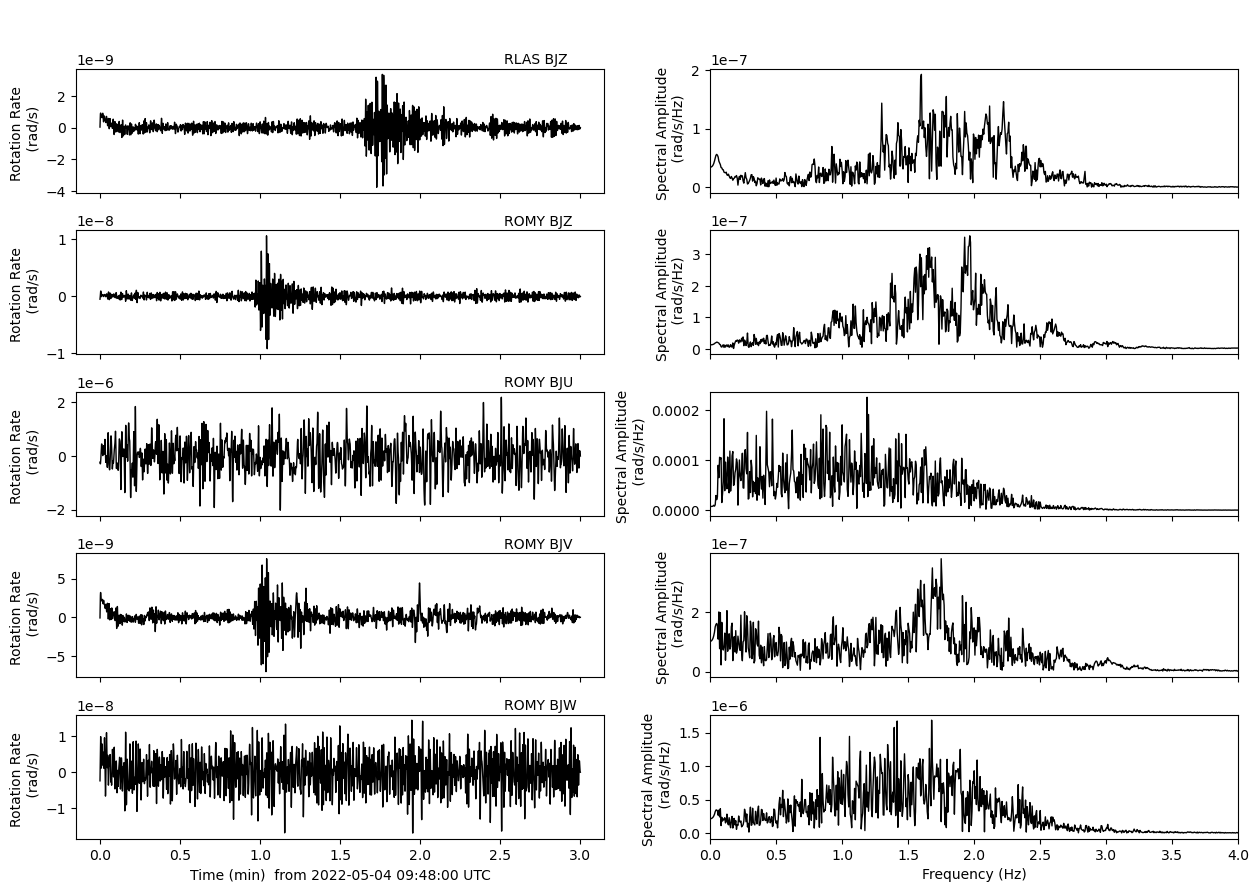

In [35]:
from scipy import fftpack

def __makeplot_sectra(st):

    plt.style.use('default')


    fig, axes = plt.subplots(5,2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________


    for i, tr in enumerate(st):


        comp_fft = np.abs(fftpack.fft(tr.data))
        ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
        comp_fft = fftpack.fftshift(comp_fft)


        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()/60,
                    tr.data,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].plot(
                    ff[1:len(ff)//2],
                    np.abs(fftpack.fft(tr.data)[1:len(ff)//2]),
                    color='black',
                    lw=1.0,
                    )


        
        axes[i,0].set_ylabel(f'Rotation Rate \n (rad/s)')    
        axes[i,1].set_ylabel('Spectral Amplitude \n (rad/s/Hz)')        
#         axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        axes[i,0].annotate('{} {}'.format(tr.stats.station, tr.stats.channel), 
                           xy=(0.4,0.928+i*-0.181),
                           xycoords='figure fraction', 
                           )
    
        if config.filter_type == "bp":
            axes[i,1].annotate('{}-{} Hz'.format(config.corner_frequency['lower'], config.corner_frequency['upper']), xy=(0.87,0.90+i*-0.18), xycoords='figure fraction')
        elif config.filter_type == "lp":
            axes[i,1].annotate('<{} Hz'.format(config.corner_frequency['upper']), xy=(0.87,0.90+i*-0.18), xycoords='figure fraction')
        elif config.filter_type == "hp":
            axes[i,1].annotate('>{} Hz'.format(config.corner_frequency['lower']), xy=(0.87,0.90+i*-0.18), xycoords='figure fraction')
        

#         axes[i,1].set_yscale('logit')

        if i == len(st)-1:
            axes[i,0].set_xlabel('Time (min)  from {} {} UTC'.format(tr.stats.starttime.date, str(tr.stats.starttime.time)[0:8]))
            axes[i,1].set_xlabel('Frequency (Hz)')



    if config.corner_frequency['upper'] is not None:
        axes[i,1].set_xlim(0, 2*config.corner_frequency['upper'])


    return fig


## __________________________________

fig = __makeplot_sectra(st)


if config.save_figs:
    __savefig(fig, outpath=opathfigs, outname=f"TraceSpectrum_{config.tbeg.date}"+".png", mode="png");

In [36]:
def __get_timeaxis(tr):
    return np.arange(0, tr.stats.npts*tr.stats.delta, tr.stats.delta)
    

In [37]:
def __makeplot_traces_and_spectrograms():

    
    def __get_timeaxis(tr):
#         return np.arange(0, tr.stats.npts*tr.stats.delta, tr.stats.delta)
        return np.linspace(0, tr.stats.npts, tr.stats.npts)*tr.stats.delta
       
        
    nfft=512
    
    fig, ax = plt.subplots(int(len(config.seeds)*2), 1, figsize=(15,12), sharex=True)

    fig.subplots_adjust(hspace=0.4)

    i, ims = 0, []
    for tr in st:


        timeaxis = __get_timeaxis(tr)
        ax[i].plot(timeaxis, tr.data, 'k', lw=0.5);


        ax[i].set_xlim(min(timeaxis), max(timeaxis))
        ax[i].set_ylabel(r"$\Omega$ (rad/s)")

#         ax[i].annotate('{} {}'.format(tr.stats.station, tr.stats.channel), 
#                         xy=(0.15,0.93+i*-0.09),
#                         xycoords='figure fraction', 
#                         )  

        
#         ff, tt, spec = scipy.signal.spectrogram(x, fs=1.0, window='tukey', 0.25, nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, mode='psd')
        spec,  f, t, cax  = ax[i+1].specgram(tr.data,  
                                             Fs=tr.stats.sampling_rate, 
                                             mode='psd', 
                                             cmap='inferno',
                                             NFFT=nfft, 
                                             Fc=None, 
                                             detrend=None, 
                                             window=np.hanning(nfft), 
                                             noverlap=int(0.5*nfft), 
                                             pad_to=None, 
                                             sides='onesided', 
                                             scale_by_freq=True,  
                                             scale='dB', 
                                             vmin=None, 
                                             vmax=None,
                                            )
                                             
        if config.corner_frequency['upper'] is not None:
            ax[i+1].set_ylim(0, 2*config.corner_frequency['upper'])
        
        ax[i+1].set_xlim(min(timeaxis), max(timeaxis))
        ax[i+1].set_ylabel("f (Hz)")
        ax[len(st)*2-1].set_xlabel('time (s)  from {} {} UTC'.format(tr.stats.starttime.date, str(tr.stats.starttime.time)[0:8]), labelpad=10)
        
        ax[i+1].annotate('{} {}'.format(tr.stats.station, tr.stats.channel), 
                        xy=(0.036,0.85+i*-0.094),
                        xycoords='figure fraction', 
                        rotation=90,
                        fontsize=12,
                        )   

        ## compute limits for colormap
        if i == 4:
            lim1=10*np.log10(np.max(spec))
            lim2=10*np.log10(np.min(spec))+200     
            
            
        ims.append(cax)    
        i+=2


    ## adjust colormap
    for im in ims:
#         im.set_clim((-220,-160))
        im.set_clim((lim2,lim1))

    fig.colorbar(ims[0], ax=ax,label='PSD (dB) rel. to 1 rad/s/Hz',pad=0.02)

    return fig



## __________________________

fig = __makeplot_traces_and_spectrograms();


# if config.save_figs:
#     __savefig(fig, outpath=opathfigs, outname=f"TraceSpectrogram_{config.tbeg.date}"+".png", mode="png");

ValueError: minvalue must be less than or equal to maxvalue

<Figure size 1500x1200 with 11 Axes>

In [38]:
from scipy.signal import correlate

cross_corr = correlate(st[1], st[0], mode='same', method='direct')

shift = np.argmax(cross_corr) - len(cross_corr)//2


   -> saving /home/brotzer/Desktop/tmp/CrossCorr_G_and_Z_2022-05-04.png.png ...

   -> Done



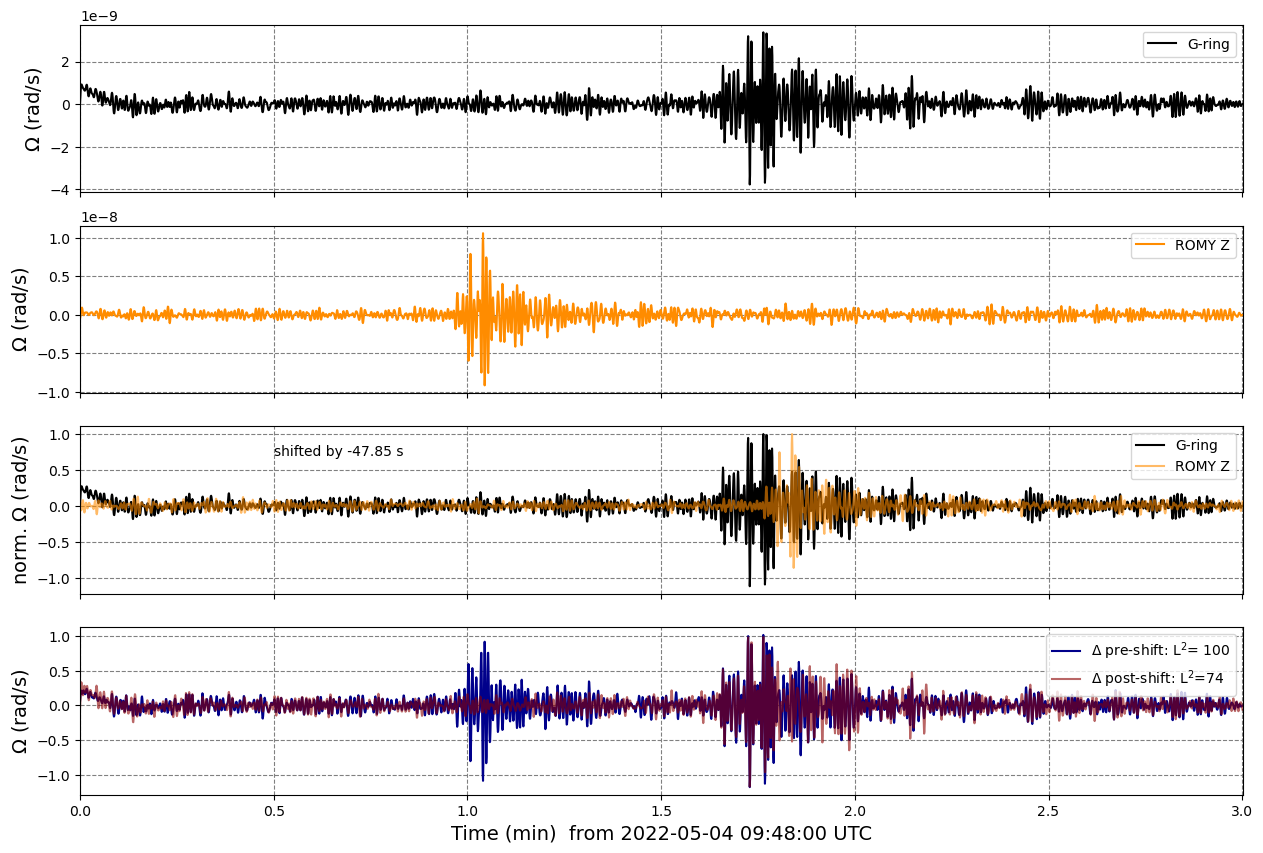

In [39]:

def __makeplot_comparison_Z():

    
    N = 4
    fig, ax = plt.subplots(N, 1, figsize=(15,10), sharex=True)

    fs=14
    
    def __get_timeaxis(tr):
#         return np.arange(0, tr.stats.npts*tr.stats.delta, tr.stats.delta)
        return np.linspace(0, tr.stats.npts, tr.stats.npts)* tr.stats.delta
       

    timeaxis1 = __get_timeaxis(st[0])/60
    timeaxis2 = __get_timeaxis(st[1])/60

    shifted_data = np.roll(st[1].data, -shift)

    Delta1 = st[0].data/max(st[0].data) - st[1].data/max(st[1].data)
    Delta2 = st[0].data/max(st[0].data) - shifted_data/max(shifted_data) 


    ax[0].plot(timeaxis1, st[0].data, color='black', label="G-ring")
    ax[0].set_ylabel(r"$\Omega$ (rad/s)", fontsize=fs)

    
    ax[1].plot(timeaxis2, st[1].data, color='darkorange', label="ROMY Z")
    ax[1].set_ylabel(r"$\Omega$ (rad/s)", fontsize=fs)

    ax[2].plot(timeaxis1, st[0].data/max(st[0].data), color='black', label="G-ring")
    ax[2].plot(timeaxis2, shifted_data/max(shifted_data), color='darkorange', alpha=0.6, label="ROMY Z")
    ax[2].set_ylabel(r"norm. $\Omega$ (rad/s)", fontsize=fs)
    ax[2].annotate(f'shifted by {round(shift*st[1].stats.delta,3)} s', xy=(0.5,0.7), zorder=1)

    ax[3].plot(timeaxis1, Delta1, color='darkblue', label=rf"$\Delta$ pre-shift: L$^2$= {int(sum(Delta1**2))}")
    ax[3].plot(timeaxis1, Delta2, color='darkred', alpha=0.6, label=rf"$\Delta$ post-shift: L$^2$={int(sum(Delta2**2))}")

    ax[3].set_ylabel(r"$\Omega$ (rad/s)", fontsize=fs)

    
    for k in range(N):
        ax[k].grid(color='grey', ls='--', zorder=0)
        ax[k].set_xlim(np.min([timeaxis1, timeaxis2]), np.max([timeaxis1, timeaxis2]))
        ax[k].legend(fontsize=fs-4, loc="upper right")
        
    ax[N-1].set_xlabel(f'Time (min)  from {config.tbeg.date} {str(config.tbeg.time)[0:8]} UTC', fontsize=fs)

    
    return fig



## __________________________

fig = __makeplot_comparison_Z()

if config.save_figs:
    __savefig(fig, outpath=opathfigs, outname=f"CrossCorr_G_and_Z_{config.tbeg.date}"+".png", mode="png");

962


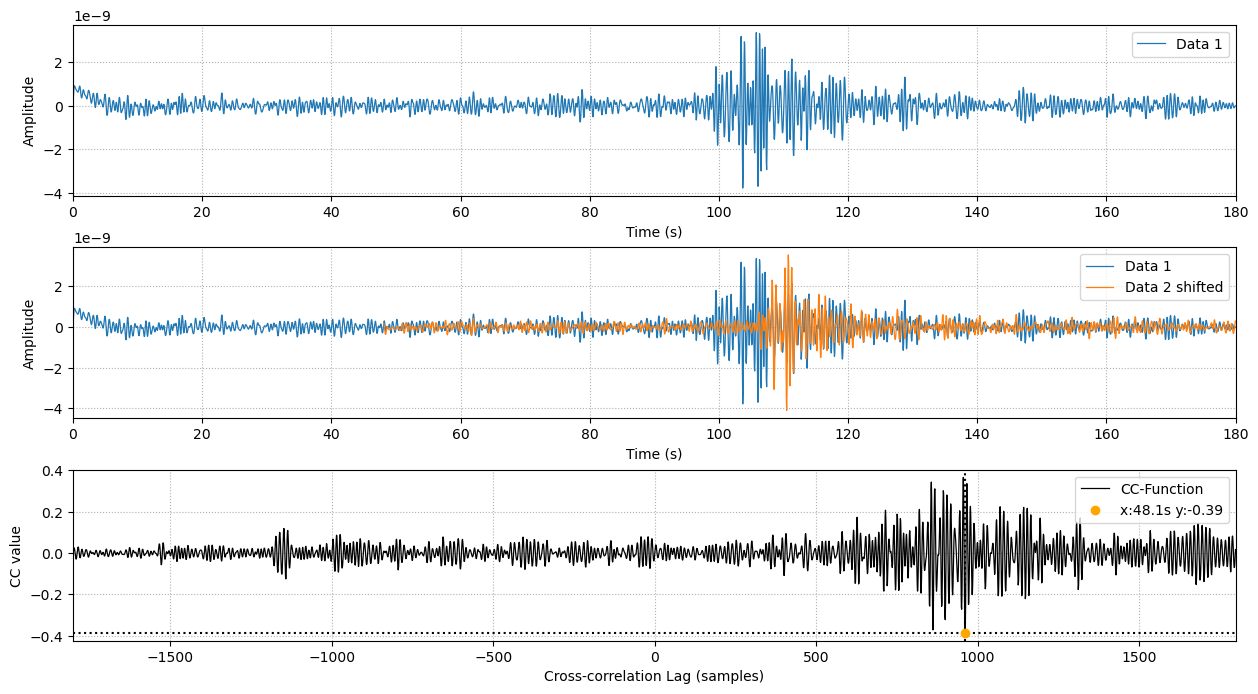

Maximum Correlation: 
 x: 962 
 y: -0.39


In [40]:
from andbro__crosscorrelation import __crosscorrelation

out = __crosscorrelation(st[0].data, st[1].data, deltaT=st[0].stats.delta)